In [0]:
import pydicom
import glob, pylab
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from PIL import Image
import numpy as np

import pydicom as dicom
import os
import cv2
import random

from numpy import savez_compressed
from keras.preprocessing import image
from numpy import load

from keras.preprocessing import image

import tensorflow as tf
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from numpy import savez_compressed
from tensorflow.keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
Dir = 'E:/Dataset/deep learning dataset/'
num_of_images= len(os.listdir(Dir + 'images'))
num_of_images

26684

In [0]:
df = pd.read_csv(Dir+'data_labels.csv')
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


## Exploratory Data Analysis

In [0]:
df = df.drop_duplicates('patientId')

In [0]:
df.Target.value_counts()

0    20672
1     6012
Name: Target, dtype: int64

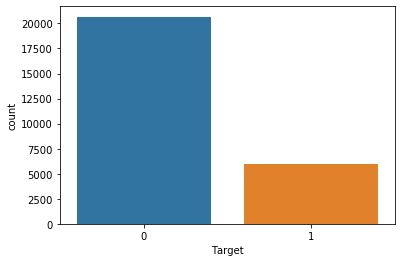

In [0]:
sns.countplot(x='Target', data = df)

In [0]:
df_heat = df.dropna()[['x', 'y', 'width', 'height']].copy()
df_heat['x_2'] = df_heat['x'] + df_heat['width']
df_heat['y_2'] = df_heat['y'] + df_heat['height']
df_heat['x_center'] = df_heat['x'] + df_heat['width'] / 2
df_heat['y_center'] = df_heat['y'] + df_heat['height'] / 2
df_heat['area'] = df_heat['width'] * df_heat['height']

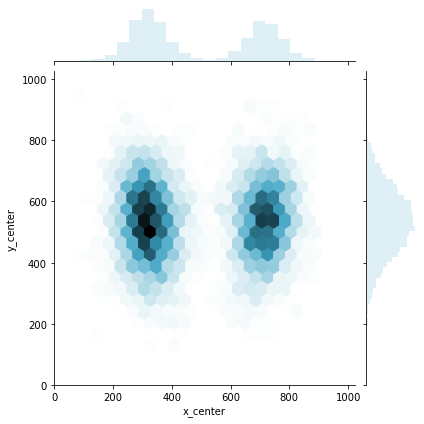

In [0]:
sns.jointplot(x = 'x_center', y = 'y_center', data = df_heat, kind = 'hex', gridsize = 20,ylim = (0,1024),xlim=(0, 1024), color = 'lightblue')

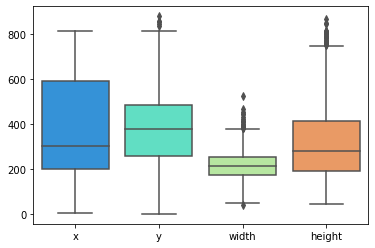

In [0]:
sns.boxplot(data=df_heat[['x','y','width','height']],palette='rainbow')

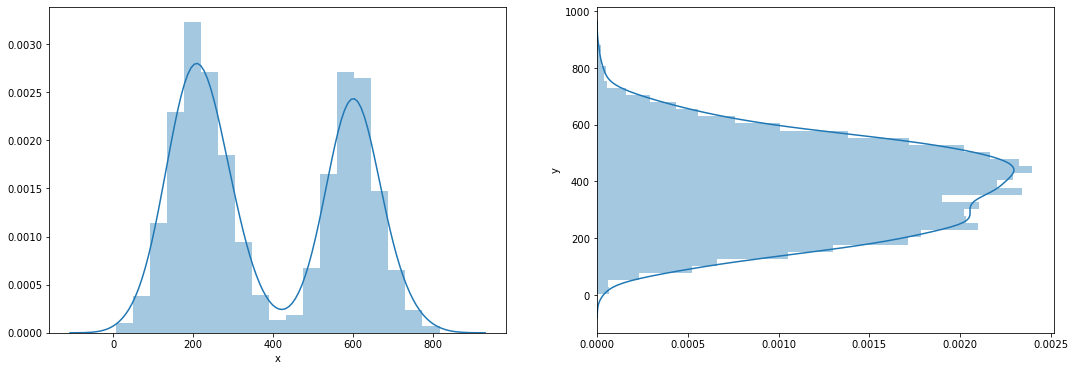

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(df_heat['x'], ax =ax[0])
sns.distplot(df_heat['y'], ax= ax[1], vertical = True)

In [0]:
# load and shuffle images
image_names = os.listdir(Dir + 'images')
random.seed(234)
random.shuffle(image_names)
image_names[0:10]

['4a21a2af-8822-43aa-9dcd-6b412dcb3d43.dcm',
 '147ee547-5c08-4169-8a4b-4785b90c54bc.dcm',
 '5e372d86-f71e-40e7-9ea3-bc0182904214.dcm',
 '47755c72-c865-44a8-846e-5b69e0142638.dcm',
 'b0f36ca4-84c4-4f1e-8f3a-5ea439cee63e.dcm',
 'b5c6d71a-3493-458c-bcb7-f174d8cdb8bc.dcm',
 '53bae9fc-3bb2-4684-b986-84bf7aa2e5a2.dcm',
 'bc59d7f5-e65b-4cc1-a668-4517ab02d974.dcm',
 '28bcb9b0-b5a9-4631-81d0-0b889807ab49.dcm',
 'f1cd74f1-90d8-419b-af77-6767c596219c.dcm']

In [0]:
# split into train, validation, test filenames
number_train_samples = round(num_of_images * 0.7)
number_valid_samples = round(num_of_images * 0.2)
number_test_samples = num_of_images - number_train_samples - number_valid_samples

train_image = image_names[:number_train_samples]
valid_image = image_names[number_train_samples:number_train_samples+ number_valid_samples]
test_image = image_names[number_train_samples+ number_valid_samples:]

print('number of train samples', len(train_image))
print('number of valid samples', len(valid_image))
print('number of test samples', len(test_image))

number of train samples 18679
number of valid samples 5337
number of test samples 2668


In [0]:
# split csv file
train_name = [i.split('.')[0] for i in train_image]
valid_name = [i.split('.')[0] for i in valid_image]
test_name = [i.split('.')[0] for i in test_image]

print(train_name[0:1])
print(valid_name[0:1])
print(test_name[0:1])

['4a21a2af-8822-43aa-9dcd-6b412dcb3d43']
['d974dbc0-5e7d-4aac-bda5-f29096aeeb5a']
['05ee72bf-6d12-4ac5-a47e-f43a7ea52a40']


In [0]:
df['validation'] =0
df.loc[df.patientId.isin(train_name), 'validation'] = 'train'
df.loc[df.patientId.isin(valid_name),'validation'] = 'validation'
df.loc[df.patientId.isin(test_name),'validation'] ='test'

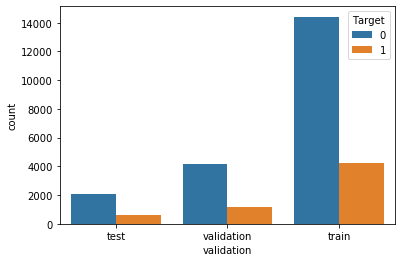

In [0]:
sns.countplot(x = 'validation', data =df, hue = 'Target')

In [0]:
df.head()

,patientId,x,y,width,height,Target,validation
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,test
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,validation
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,validation
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,train
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,train


In [0]:
train = df.loc[df.patientId.isin(train_name)]
valid = df.loc[df.patientId.isin(valid_name)]
test = df.loc[df.patientId.isin(test_name)]

print('number of train samples', train.shape)
print('number of valid samples', valid.shape)
print('number of test samples', test.shape)

number of train samples (18679, 7)
number of valid samples (5337, 7)
number of test samples (2668, 7)


In [0]:
print(train.Target.value_counts()[0]/train.Target.value_counts()[1])
print(valid.Target.value_counts()[0]/valid.Target.value_counts()[1])
print(test.Target.value_counts()[0]/test.Target.value_counts()[1])

3.379601406799531
3.657068062827225
3.4392678868552413


# Load Image Data

In [0]:
health_person_patientId ='0004cfab-14fd-4e49-80ba-63a80b6bddd6'
dcm_file = Dir+'images/'+'%s.dcm' % health_person_patientId
dcm_data = pydicom.read_file(dcm_file)

In [0]:
print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [0]:
im = dcm_data.pixel_array

(-0.5, 1023.5, 1023.5, -0.5)

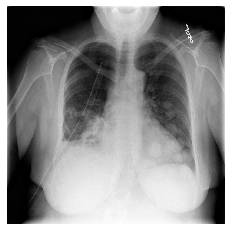

In [0]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

#### Add bounding box

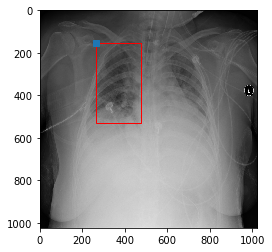

In [0]:
# Create Bounding box for images
row = df.loc[df['patientId'] == '00436515-870c-4b36-a041-de91049b9ab4']
unhealth_person_patientId ='00436515-870c-4b36-a041-de91049b9ab4'
dcm_file_1 = Dir+'images/'+'%s.dcm' % unhealth_person_patientId
dcm_data_1 = pydicom.read_file(dcm_file_1)
im_1 = dcm_data_1.pixel_array
fig,ax = plt.subplots(1)
pylab.imshow(im_1, cmap=pylab.cm.gist_gray)
pylab.axis('on')
pylab.plot(row['x'], row['y'], 's')
rect = patches.Rectangle(xy=(row.loc[4,'x'], row.loc[4,'y']),width=row.loc[4,'width'],
                         height=row.loc[4,'height'],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

In [0]:
unhealthy = df.loc[df.Target==1]
unhealthy.reset_index(inplace = True, drop =True)
unhealthy_example = unhealthy[0:9]
unhealthy_example

,patientId,x,y,width,height,Target,validation
0,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,train
1,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,validation
2,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,validation
3,00c0b293-48e7-4e16-ac76-9269ba535a62,306.0,544.0,168.0,244.0,1,test
4,00f08de1-517e-4652-a04f-d1dc9ee48593,181.0,184.0,206.0,506.0,1,train
5,0100515c-5204-4f31-98e0-f35e4b00004a,703.0,416.0,84.0,77.0,1,train
6,010ccb9f-6d46-4380-af11-84f87397a1b8,652.0,437.0,161.0,293.0,1,train
7,012a5620-d082-4bb8-9b3b-e72d8938000c,133.0,613.0,275.0,275.0,1,train
8,0174c4bb-28f5-41e3-a13f-a396badc18bd,155.0,182.0,273.0,501.0,1,validation


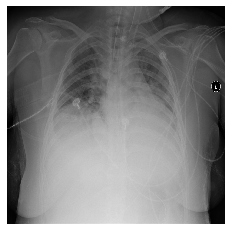

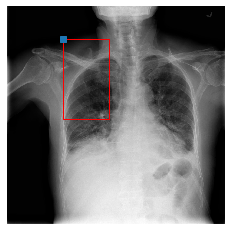

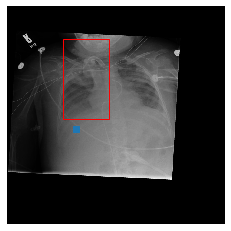

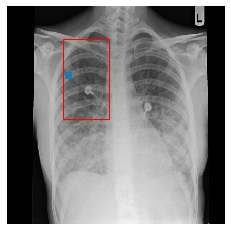

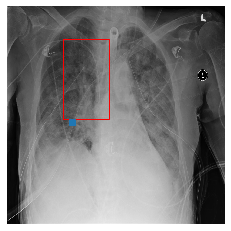

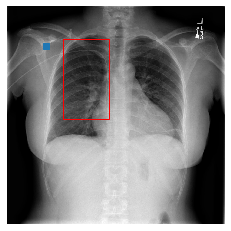

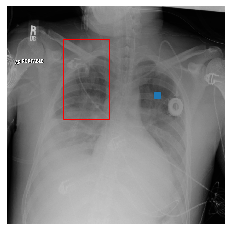

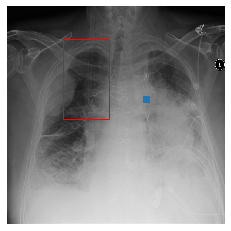

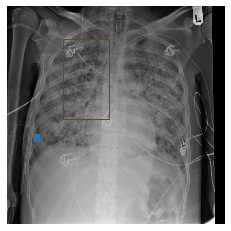

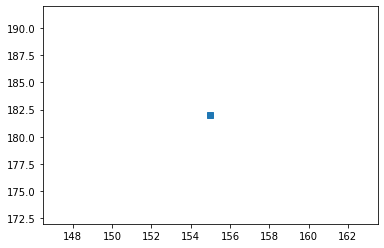

In [0]:
for patient in unhealthy_example['patientId']:
    i =0
    row = unhealthy_example.loc[unhealthy_example['patientId'] == patient]
    dcm_file = Dir+'images/'+'%s.dcm' % patient
    dcm_data = pydicom.read_file(dcm_file)
    im = dcm_data.pixel_array
    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')
    fig,ax = plt.subplots(1)
    pylab.plot(row['x'], row['y'], 's')
    rect = patches.Rectangle(xy=(unhealthy_example.loc[i,'x'],
                                 unhealthy_example.loc[i,'y']),
                             width=unhealthy_example.loc[i,'width'],
                             height=unhealthy_example.loc[i, 'height'],
                             linewidth=1,edgecolor='r',facecolor='none')
    i+=1
    ax.add_patch(rect)

#### Convert dcm into jpg format

In [0]:
# Specify the .dcm folder path
folder_path = "E:\Dataset\stage_2_train_images"
# Specify the output jpg/png folder path
jpg_folder_path = "E:\Dataset\JPG_train"
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    ds = dicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    image = image.replace('.dcm', '.png')
    cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
    if n % 1000 == 0:
        print('{} image converted'.format(n))

#### Split the data into training, validation, testing datasets

In [0]:
# Create folders for train, validation and test
import shutil
jpg_path = 'E:/Dataset/JPG_train/'
for f in train_name:
    shutil.move(jpg_path+ f +'.jpg', 'E:/Dataset/train')

In [0]:
for f in valid_name:
    shutil.move(jpg_path+ f +'.jpg', 'E:/Dataset/validation')
for f in test_name:
    shutil.move(jpg_path+ f +'.jpg', 'E:/Dataset/test')

In [0]:
train.sort_values('patientId',inplace = True)
train.reset_index(inplace = True,drop = True)
train_image.sort()
train[0:5]

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,patientId,x,y,width,height,Target,validation
0,001031d9-f904-4a23-b3e5-2c088acd19c6,66.0,160.0,373.0,608.0,1,train
1,0010f549-b242-4e94-87a8-57d79de215fc,NaN,NaN,NaN,NaN,0,train
2,0022073f-cec8-42ec-ab5f-bc2314649235,575.0,232.0,246.0,528.0,1,train
3,0022995a-45eb-4cfa-9a59-cd15f5196c64,NaN,NaN,NaN,NaN,0,train
4,002c591d-df62-4e34-8eda-838c664430a9,NaN,NaN,NaN,NaN,0,train


In [0]:
train_name.sort()
train_name[0:5]

['001031d9-f904-4a23-b3e5-2c088acd19c6',
 '0010f549-b242-4e94-87a8-57d79de215fc',
 '0022073f-cec8-42ec-ab5f-bc2314649235',
 '0022995a-45eb-4cfa-9a59-cd15f5196c64',
 '002c591d-df62-4e34-8eda-838c664430a9']

In [0]:
valid.sort_values('patientId',inplace = True)
valid.reset_index(inplace = True,drop = True)
valid_name.sort()
valid[0:5]

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,patientId,x,y,width,height,Target,validation
0,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,validation
1,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,validation
2,001916b8-3d30-4935-a5d1-8eaddb1646cd,198.0,375.0,114.0,206.0,1,validation
3,0025d2de-bd78-4d36-9f72-e15a5e22ca82,NaN,NaN,NaN,NaN,0,validation
4,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,validation


In [0]:
valid_name[0:5]

['000924cf-0f8d-42bd-9158-1af53881a557',
 '000db696-cf54-4385-b10b-6b16fbb3f985',
 '001916b8-3d30-4935-a5d1-8eaddb1646cd',
 '0025d2de-bd78-4d36-9f72-e15a5e22ca82',
 '00313ee0-9eaa-42f4-b0ab-c148ed3241cd']

In [0]:
test.sort_values('patientId',inplace = True)
test.reset_index(inplace = True,drop = True)
test_name.sort()
test[0:5]

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,patientId,x,y,width,height,Target,validation
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,test
1,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,test
2,00293de0-a530-41dc-9621-0b3def01d06d,NaN,NaN,NaN,NaN,0,test
3,00c0b293-48e7-4e16-ac76-9269ba535a62,306.0,544.0,168.0,244.0,1,test
4,00eeb3c9-a892-4fac-a67a-aaa6cc7ffd5c,670.0,453.0,233.0,336.0,1,test


In [0]:
test_name[0:5]

['0004cfab-14fd-4e49-80ba-63a80b6bddd6',
 '000fe35a-2649-43d4-b027-e67796d412e0',
 '00293de0-a530-41dc-9621-0b3def01d06d',
 '00c0b293-48e7-4e16-ac76-9269ba535a62',
 '00eeb3c9-a892-4fac-a67a-aaa6cc7ffd5c']

In [0]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

train_images = []
train_path = 'E:/Kaggle Dataset/train/'
for n, file in enumerate(train_name):
    
    img_path = train_path + file+'.jpg'
    img = tf.io.read_file(img_path)
    
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    resize_image = tf.image.resize(img, [340, 340])
    resize_image = resize_image.numpy()
    train_images.append(resize_image)
    if n % 1000 == 0:
        print('{} image loaded'.format(n))
train_images = np.array(train_images)
train_images.shape

0 image loaded
1000 image loaded
2000 image loaded
3000 image loaded
4000 image loaded
5000 image loaded
6000 image loaded
7000 image loaded
8000 image loaded
9000 image loaded
10000 image loaded
11000 image loaded
12000 image loaded
13000 image loaded
14000 image loaded
15000 image loaded
16000 image loaded
17000 image loaded
18000 image loaded


(18679, 340, 340, 1)

In [0]:
valid_images = []
valid_path = 'E:/Kaggle Dataset/validation/'
for n, file in enumerate(valid_name):
    
    img_path = valid_path + file+'.jpg'
    img = tf.io.read_file(img_path)
    
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    resize_image = tf.image.resize(img, [340, 340])
    resize_image = resize_image.numpy()
    valid_images.append(resize_image)
    if n % 1000 == 0:
        print('{} image loaded'.format(n))
valid_images = np.array(valid_images)
valid_images.shape

0 image loaded
1000 image loaded
2000 image loaded
3000 image loaded
4000 image loaded
5000 image loaded


(5337, 340, 340, 1)

In [0]:
test_images = []
test_path = 'E:/Kaggle Dataset/test/'
for n, file in enumerate(test_name):
    
    img_path = test_path + file+'.jpg'
    img = tf.io.read_file(img_path)
    
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    resize_image = tf.image.resize(img, [340, 340])
    resize_image = resize_image.numpy()
    test_images.append(resize_image)
    if n % 1000 == 0:
        print('{} image loaded'.format(n))
test_images = np.array(test_images)
test_images.shape  

0 image loaded
1000 image loaded
2000 image loaded


(2668, 340, 340, 1)

#### Save as NPZ file 

In [0]:
savez_compressed('val_data_1.npz', valid_images)
savez_compressed('test_data_1.npz', test_images)
savez_compressed('train_data_1.npz', train_images)